<a href="https://colab.research.google.com/github/DSteinmann/HSG-AIML-CC/blob/AP/fromscratchmodel_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="center" style="max-width: 900px; height: auto" src="https://github.com/DSteinmann/HSG-AIML-CC/blob/assets/banner.png?raw=1">

###  Coding Challenge - Getting Started

<img align="right" style="max-width: 200px; height: auto" src="https://github.com/DSteinmann/HSG-AIML-CC/blob/AP/hsg_logo.png?raw=1">
<img align="center" style="max-width: 300px; height: auto" src="https://github.com/DSteinmann/HSG-AIML-CC/blob/AP/sentinel2.jpg?raw=1">

8,860,1.00 MCS Machine Learning, Spring Term 2025, University of St.Gallen (HSG)

The lab environment of the **8,860,1.00 Machine Learning** course is powered by Jupyter Notebooks (https://jupyter.org), which allows one to perform a great deal of data analysis and statistical validation. In this first lab, we want to touch on the basic concepts and techniques of such notebooks. Furthermore, its capabilities will be demonstrated based on a few simple and introductory examples.

### Objectives:

With the help of this notebook you should be able to:
    
> 1. Understand the basic funcitonality of the rasterio framework
> 2. Apply rasterio to load GTiff data
> 3. Visualize multi-band satellite imagery
> 4. Perform basic band arithmetic to compute the normalized difference vegetation index (NDVI)
> 5. Load and display samples from the challenge testset

## 2. Setup of the Jupyter Notebook Environment

Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will use `os` and `glob` to collect the filepaths for the data samples, `numpy` for array operations, `matplotlib` to display images, and `rasterio` to handle raster data. You can find the documentation of the `rasterio` library with an overview of its functionality [here](https://rasterio.readthedocs.io).

In [ ]:


!pip install rasterio
import os
import glob
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
%matplotlib inline



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 17.7 MB/s eta 0:00:00


### Dataset Download
<img align="center" style="max-width: 300px; height: auto" src="https://github.com/DSteinmann/HSG-AIML-CC/blob/AP/eurosat.png?raw=1">

The Eurosat dataset is available on [github](https://github.com/phelber/EuroSAT). You can download and unpack the data from there. Note that this repository includes RGB and multi-spectral versions of Eurosat. Note that the testdata is multi-spectral.

The multi-spectral (MS) version can be downloaded with the following command:

In [ ]:


!wget https://madm.dfki.de/files/sentinel/EuroSATallBands.zip --no-check-certificate



--2025-04-09 08:30:56--  https://madm.dfki.de/files/sentinel/EuroSATallBands.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 2067725275 (1.9G) [application/zip]
Saving to: ‘EuroSATallBands.zip’

EuroSATallBands.zip 100%[===================>]   1.92G  11.5MB/s    in 3m 53s  

2025-04-09 08:34:50 (8.46 MB/s) - ‘EuroSATallBands.zip’ saved [2067725275/2067725275]



In [ ]:
#unzip file
!unzip -q EuroSATallBands.zip

### Eurosat classes

The class-labels can be derived from the directory structure of the downloaded `zip` file. The 10 classes are as follows:

In [ ]:
classes = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake",
]

### Data visualization
Let's define a function to visualize the Eurosat data with `matplotlib`. In the 13-band multispectral images of Sentinel-2, the 13 values of each pixel correspond to the reflectance values at different wavelengths. These numbers are not normalized for visualization with `matplotlib`, which expects inputs to be `int` in the `[0-255]` or `float` in the `[0.-1.]` range.

In [ ]:
def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands.
    The input is expected to be in HxWxC format, e.g. 64x64x13.
    To account for outliers (e.g. extremly high values due to
    reflective surfaces), we normalize with the 2- and 98-percentiles
    instead of minimum and maximum of each band.
    """
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))

    return (band_data - lower_perc) / (upper_perc - lower_perc)

## EuroSat Data Loading

First, let's collect all the files that we downloaded

In [ ]:
# change this to your eurosat path
eurosat_dir = "./ds/images/remote_sensing/otherDatasets/sentinel_2/tif"

In [ ]:
samples = glob.glob(os.path.join(eurosat_dir, "*", "*.tif"))
len(samples)

27000

We have 27,000 files across 10 classes.

Let's load one of those multi-spectral images and try to visualize it.

In [ ]:
sample_idx = 1
sample = samples[sample_idx]
label = sample.split('/')[-1].split('_')[0]

We can use `rasterio.open` to open the `GTiff` file. We can then `read` from the file. By default `read()` without arguments will load all bands. Individual bands can be specified as a list with one-based indices. Therefore, the RGB bands can be read with `read([4,3,2])`.

In [ ]:
with rio.open(sample, "r") as d:
    # img = d.read() # read all bands

    # read specific bands:
    # B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12
    img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])

img.shape

(13, 64, 64)

We load the data into the `img` variable. This results in a `numpy` array with shape `(13,64,64)`, i.e. `CxHxW`. This differs from the convention of most image libraries like `matplotlib`, which work on image data in the `HxWxC` orientation. `rasterio` provides a function to easily fix this:

In [ ]:
img = reshape_as_image(img)
img.shape

(64, 64, 13)

Now let's normalize the data.

In [ ]:
normalized_img = normalize_for_display(img)

Finally, we can extract the RGB bands and visualize them with `matplotlib`.

In [ ]:
rgb_img = normalized_img[:, :, [3,2,1]]

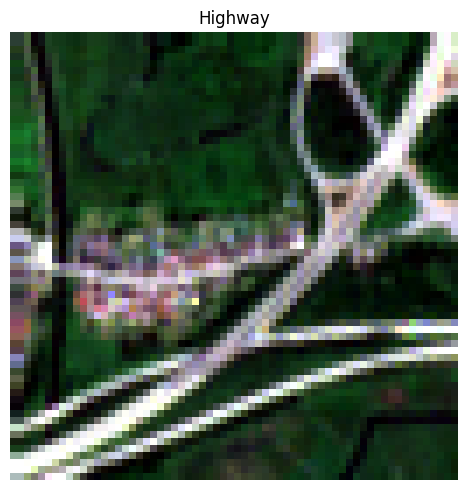

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(rgb_img)
ax.set_title(f"{label}")
ax.axis(False)
plt.tight_layout()

plt.show()

Note the `matplotlib` warning. Since we normalized the data by percentiles instead of maximum and minimum some (rare) pixels exceed the `[0.-1.]` range that `matplotlib` can handle. In such cases, the values are clipped to `1.`.

# Testset Data Loading

The testset has a slightly different structure than Eurosat. There are no labels and the data is stored in `numpy` `.npy` instead of GTiff.

First, we have to download the data from [Kaggle](https://www.kaggle.com/competitions/8-860-1-00-coding-challenge-2025/data).

In [ ]:
!pip install kaggle
!kaggle competitions download -c 8-860-1-00-coding-challenge-2025
#unzip
!unzip -q 8-860-1-00-coding-challenge-2025.zip

In [ ]:
testset_dir = os.path.join("./testset/", "testset")
test_samples = glob.glob(os.path.join(testset_dir, "*.npy"))
len(test_samples)

4232

Now let's visualize a sample as we did for Eurosat

In [ ]:
test_idx = 0

In [ ]:
test_img = np.load(test_samples[test_idx])
test_img.shape

(64, 64, 12)

Then normalize the data and extract RGB channels

In [ ]:
normalized_img = normalize_for_display(test_img)

In [ ]:
rgb_img = normalized_img[:, :, [3,2,1]]

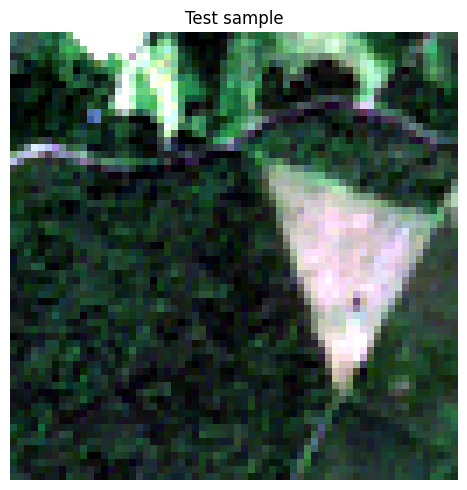

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(rgb_img)
ax.set_title(f"Test sample")
ax.axis(False)
plt.tight_layout()

plt.show()

### Bonus: Band arithmetic
The normalized difference vegetation index, or NDVI, is one of the most useful indices that can be derived from multi-spectral remote sensing data and indicates the presence of live green vegeation in an area.

> The pigment in plant leaves, chlorophyll, strongly absorbs visible light (from 400 to 700 nm) for use in photosynthesis. The cell structure of the leaves, on the other hand, strongly reflects near-infrared light (from 700 to 1100 nm).

From [Wikipedia](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)

The NDVI exploits this difference in reflective properties of plants. It is computed as the ratio of the difference with the sum of near-infrared and red color bands. For the Sentinel2 data, this corresponds to the following:

`NDVI = (B8-B4)/(B8+B4)`

In [ ]:
sample = samples[10]
label = sample.split('/')[-1].split('_')[0]

with rio.open(sample, "r") as d:
    img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])

img = reshape_as_image(img)
normalized_img = normalize_for_display(img)
rgb_img = normalized_img[:, :, [3,2,1]]

Extract bands 4 and 8 from the data.

In [ ]:
b8 = img[:, :, 7]
b4 = img[:, :, 3]

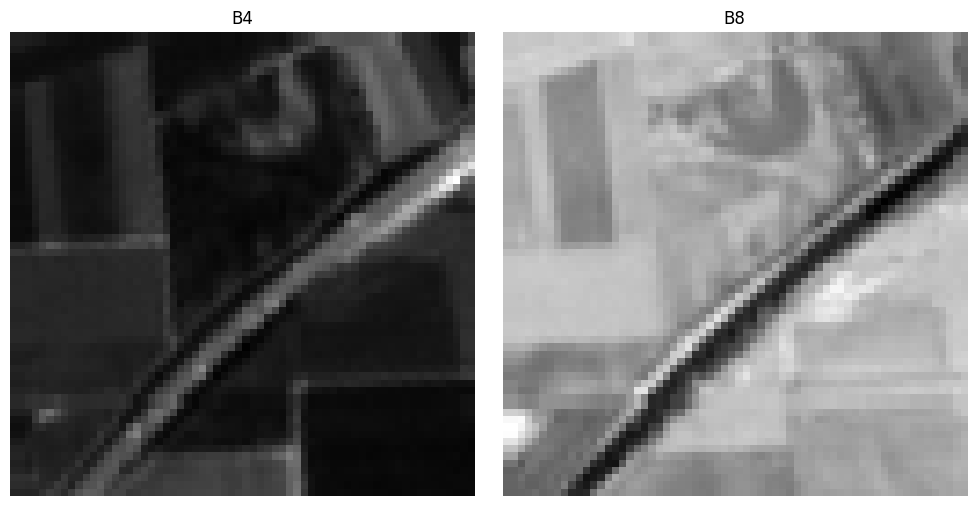

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].imshow(b4, cmap="gray")
axs[0].set_title("B4")
axs[0].axis(False)

axs[1].imshow(b8, cmap="gray")
axs[1].set_title("B8")
axs[1].axis(False)

plt.tight_layout()
plt.show()

Compute the NDVI:

In [ ]:
ndvi = (b8-b4) / (b8+b4)

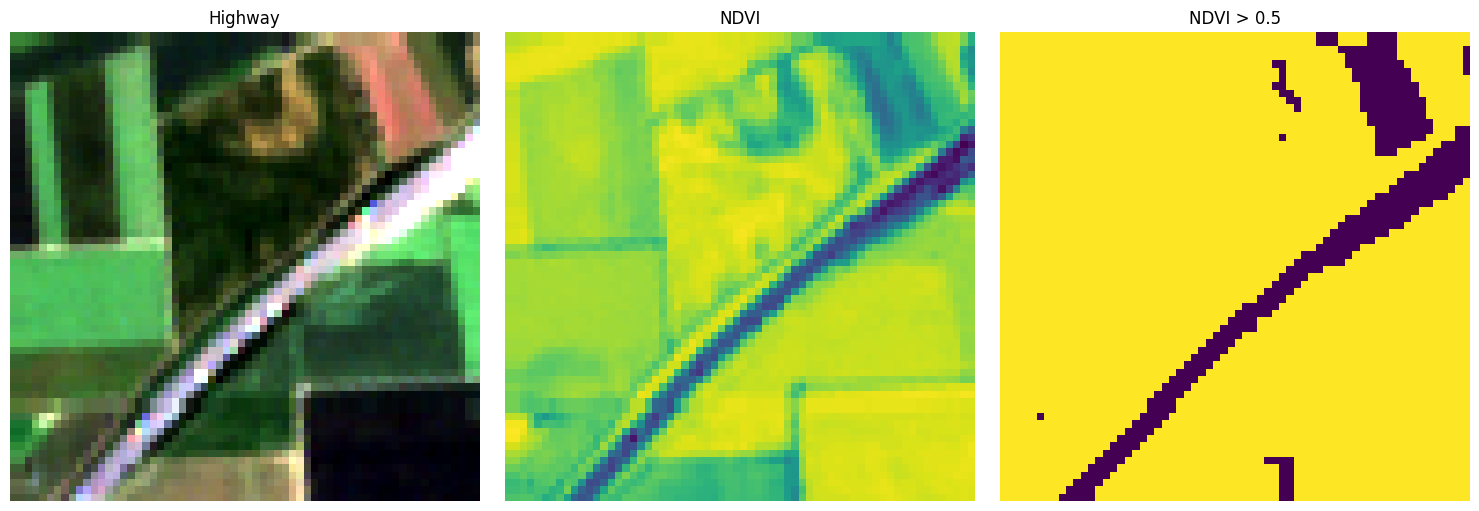

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.imshow(rgb_img)
ax1.set_title(f"{label}")
ax1.axis(False)

ax2.imshow(ndvi)
ax2.set_title(f"NDVI")
ax2.axis(False)

ax3.imshow(ndvi > .5)
ax3.set_title(f"NDVI > 0.5")
ax3.axis(False)

plt.tight_layout()
plt.show()

We can easily threshold NDVI values to obtain a segmentation mask of the vegetation in the image.

Let's also look at the bands individually.

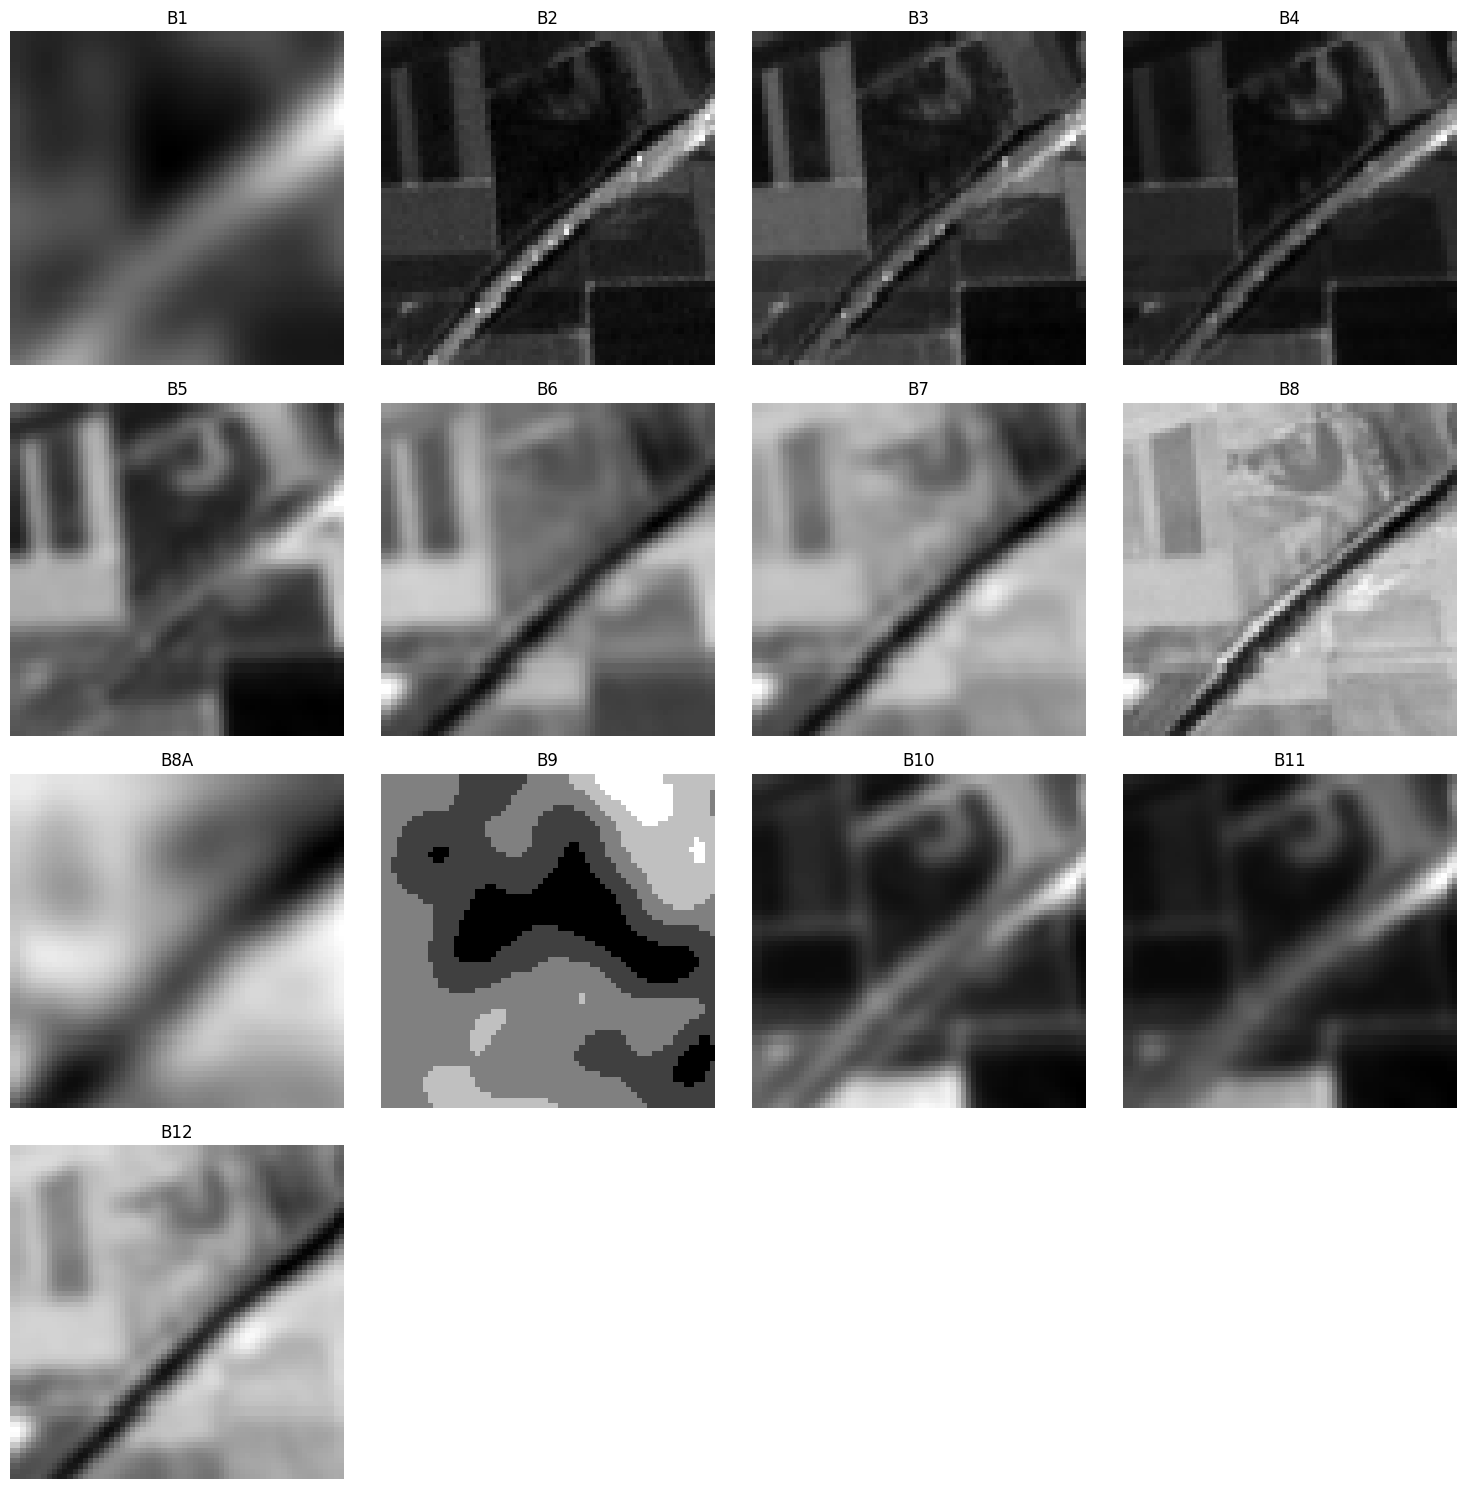

In [ ]:
fig, axs = plt.subplots(4,4, figsize=(15,15))

band_idx = 0
bands = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B10","B11","B12"]

for i in range(4):
    for j in range(4):
        if band_idx < 13:
            axs[i,j].imshow(normalized_img[:, :, band_idx], cmap="gray")
            axs[i,j].set_title(bands[band_idx])
        else:
            axs[i,j].imshow(np.ones((64,64,3)), cmap="gray")

        axs[i,j].axis(False)
        band_idx += 1

plt.tight_layout()
plt.show()

## Next steps

Create a (deep learning) model to predict the most likely Eurosat class for each image of the testset. Think about creating the dataset class and data-loader for training, possible model architectures, and perhaps even how to best address the shift between train and test data.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import models, transforms
import rasterio
import numpy as np
import torch.nn.functional as F
import pandas as pd
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import random
import time
from torch.cuda.amp import GradScaler, autocast
from torchvision.models import ResNet50_Weights, ConvNeXt_Base_Weights
from sklearn.model_selection import train_test_split
import traceback

from pathlib import Path
from tqdm import tqdm
from typing import Tuple, List, Dict, Any, Optional, Callable




In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

# with eval
✅ CBAM Attention for better feature refinement.
✅ CycleGAN for style transfer between remote sensing image domains.
✅ Progressive Learning by gradually increasing image resolution during training.


CycleGAN for Style Transfer:

    Implement a Generator (ResNet-based U-Net) and Discriminator (PatchGAN).

    Use cycle consistency loss to enforce meaningful translations.

    Train it on satellite images to generate images in a different domain (e.g., cloud-free to cloud-covered).

CBAM Attention Mechanism:

    Add Channel & Spatial Attention to enhance feature maps in your classifier.

    Improve feature learning for your Sentinel-2 classification model.

Progressive Learning:

    Train the model gradually by increasing image resolution and model complexity.

    Start training with smaller images and fewer layers, then progressively increase resolution and depth.


1️⃣ CycleGAN: Designed for Image Translation, Not Deep Feature Extraction

    CycleGAN’s generators use fewer layers (e.g., ResNet blocks) because they transform images rather than classify them.

    Too many layers could lead to blurring or loss of fine details during translation.

    Discriminators in CycleGAN use PatchGAN, which focuses on local patches instead of full-image classification.

🔹 Your CNN: Needs deep feature extraction (many layers).
🔹 CycleGAN: Focuses on learning mappings between image styles, requiring fewer layers.
2️⃣ CBAM: Lightweight Attention Mechanism

    CBAM (Convolutional Block Attention Module) is an efficiency-focused module.

    It selectively enhances important features without drastically increasing computational cost.

    It uses global pooling and small convolutions (1x1, 7x7 filters) instead of deep stacks of layers.

🔹 Your CNN: Uses deep feature extraction.
🔹 CBAM: Just adds attention to existing feature maps, not an entire deep network.
3️⃣ Your CNN is a Full Classifier, CycleGAN is for Image-to-Image Translation

    Your CNN classifier must extract complex features from Sentinel-2 images to classify land cover types (e.g., forests, water, urban areas).

    CycleGAN only needs to learn how to convert images from one domain to another (e.g., cloudy to cloud-free satellite images), requiring fewer layers.



In [ ]:

import warnings
# --- Suppress all warnings ---
warnings.filterwarnings("ignore")
##################################
# --- CBAM Attention Mechanism ---
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super(CBAM, self).__init__()
        # Channel Attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

        # Spatial Attention
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)

    def forward(self, x):
        # Channel Attention
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        channel_out = self.sigmoid(avg_out + max_out)
        x = x * channel_out

        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_out = self.sigmoid(self.conv_spatial(torch.cat([avg_out, max_out], dim=1)))
        x = x * spatial_out
        return x

# --- CycleGAN Generator ---
class ResNetBlock(nn.Module):
    def __init__(self, channels):
        super(ResNetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_res_blocks=6):
        super(Generator, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.res_blocks = nn.Sequential(*[ResNetBlock(64) for _ in range(num_res_blocks)])
        self.final = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=7, padding=3, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.res_blocks(x)
        return self.final(x)

# --- CycleGAN Discriminator ---
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, kernel_size=4, padding=1)
        )

    def forward(self, x):
        return torch.sigmoid(self.model(x))

# --- Progressive Learning: Dynamic Resizing ---
def progressive_resize(epoch, model, optimizer, initial_size=64, max_size=256):
    """ Gradually increases image size during training. """
    new_size = min(initial_size + (epoch * 16), max_size)
    global transform_train
    transform_train = transforms.Compose([
        transforms.Resize((new_size, new_size)),
        transforms.ToTensor()
    ])
    print(f"[Progressive Learning] Image size increased to: {new_size}x{new_size}")

# --- Initialize Models ---
generator_XY = Generator()
generator_YX = Generator()
discriminator_X = Discriminator()
discriminator_Y = Discriminator()

# --- Losses & Optimizers ---
cycle_loss_fn = nn.L1Loss()
gan_loss_fn = nn.BCEWithLogitsLoss()
optimizer_G = torch.optim.Adam(list(generator_XY.parameters()) + list(generator_YX.parameters()), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(list(discriminator_X.parameters()) + list(discriminator_Y.parameters()), lr=2e-4, betas=(0.5, 0.999))

# --- Training Loop (Simplified) ---
for epoch in range(100):  # Example: 100 epochs
    progressive_resize(epoch, generator_XY, optimizer_G)
    for batch in DataLoader(train_dataset, batch_size=8, shuffle=True):
        real_X, real_Y = batch  # Assuming dataset loads paired images

        fake_Y = generator_XY(real_X)
        fake_X = generator_YX(real_Y)

        cycle_X = generator_YX(fake_Y)
        cycle_Y = generator_XY(fake_X)

        loss_cycle = cycle_loss_fn(cycle_X, real_X) + cycle_loss_fn(cycle_Y, real_Y)
        loss_gan = gan_loss_fn(discriminator_Y(fake_Y), torch.ones_like(fake_Y)) + \
                   gan_loss_fn(discriminator_X(fake_X), torch.ones_like(fake_X))

        loss_G = loss_gan + 10 * loss_cycle  # Weighted cycle consistency loss
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        print(f"Epoch {epoch}, Loss_G: {loss_G.item():.4f}, Loss_Cycle: {loss_cycle.item():.4f}")

##################################
# --- Configuration ---
CONFIG = {
    "model": {
        "load_path": Path('./convnext_2stage_imgnorm.pth'),  # Path for saving/loading model
        "num_classes": None,  # Determined dynamically
        "class_names": None,  # Determined dynamically
    },
    "data": {
        "train_dir": Path('./ds/images/remote_sensing/otherDatasets/sentinel_2/tif'),
        "validation_dir": Path('./testset/testset'),
        "image_size": 128,
        "batch_size": 32,
        "num_workers": 4,
        "train_ratio": 0.9,
    },
    "train": {
        "seed": 1337,
        "lr_stage1": 1e-3,
        "lr_stage2": 1e-3,
        "stage1_epochs": 30,
        "stage2_epochs": 30,
        "warmup_epochs": 3,
        "initial_warmup_lr": 1e-6,
        "weight_decay": 3.7553e-05,
        "optimizer_name": 'AdamW',
        "patience": 10,
        "gradient_accumulation_steps": 2
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "amp_enabled": True,
    "prediction": {
        "predictions_csv_path": Path('./outputs/track_1.csv'),
        "kaggle_competition": 'aicrowd-geospatial-challenge',
        "kaggle_message": 'Evaluation Script Submission',
        "submit_to_kaggle": True,
    }
}

# --- Device Setup ---
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using device: {DEVICE}")

# --- Seed Setting ---
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG["train"]["seed"])

# --- Data Loading and Preprocessing ---
def load_sentinel2_image(filepath: str) -> np.ndarray:
    """Loads a Sentinel-2 image (TIF or NPY), returns NumPy CHW (12 bands)."""
    if filepath.endswith('.tif'):
        with rasterio.open(filepath) as src:
            if src.count < 13:
                raise ValueError(f"Expected >=13 bands, got {src.count} in {filepath}")
            bands = list(range(1, 10)) + list(range(11, 14))  # Exclude B10
            image = src.read(bands)  # Shape: (12, H, W)

    elif filepath.endswith('.npy'):
        image = np.load(filepath)  # Load .npy as is, without modification

        if image.shape[0] != 13 and image.shape[0] != 12:
            raise ValueError(f"Unexpected shape for .npy {filepath}: {image.shape}")

    else:
        raise ValueError(f"Unsupported file type: {filepath}")

    return image.astype(np.float32)

# --- Per-Image Normalization Function ---
def normalize_image_per_image(image_np: np.ndarray) -> np.ndarray:
    """Normalizes 12-channel NumPy image (C, H, W) using its own stats."""
    if image_np.ndim != 3 or image_np.shape[0] != 12:
        raise ValueError(f"Invalid shape for per-image normalization: {image_np.shape}. Expected (12, H, W).")

    mean = np.mean(image_np, axis=(1, 2), keepdims=True)  # Per-channel mean
    std = np.std(image_np, axis=(1, 2), keepdims=True)  # Per-channel std

    return (image_np - mean) / (std + 1e-7)  # Normalize & avoid division by zero

# --- Dataset Class (Using Per-Image Normalization) ---
class Sentinel2Dataset(Dataset):
    """Custom Dataset for Sentinel-2 images. Returns Tensor CHW (12 channels)."""
    def __init__(self, paths_labels, transform=None):
        self.paths_labels = paths_labels
        self.transform = transform

    def __len__(self):
        return len(self.paths_labels)

    def __getitem__(self, idx):
        image_path, label = self.paths_labels[idx]
        try:
            image_np = load_sentinel2_image(image_path) # NumPy (C, H, W)
            image_np = normalize_image_per_image(image_np) # Apply per-image normalization HERE

            image_tensor = torch.from_numpy(image_np.copy()).float() # Convert to tensor AFTER normalization
            label_tensor = torch.tensor(label, dtype=torch.long)

            if self.transform:
                image_tensor = self.transform(image_tensor) # Apply remaining transforms

            return image_tensor, label_tensor, image_path

        except Exception as e:
            print(f"Error loading/processing image {image_path}:")
            traceback.print_exc()
            return None, None, None # Signal error

# Prediction dataset also uses per-image normalization
class NpyPredictionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = sorted([os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.npy')])
        if not self.file_paths: raise FileNotFoundError(f"No .npy files in {root_dir}")
        print(f"Found {len(self.file_paths)} .npy files for prediction.")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_path = self.file_paths[idx]
        try:
            image_np = load_sentinel2_image(image_path) # NumPy (C, H, W)
            image_np = normalize_image_per_image(image_np) # Apply per-image normalization HERE
            image_tensor = torch.from_numpy(image_np.copy()).float() # Convert to tensor

            if self.transform:
                image_tensor = self.transform(image_tensor) # Apply remaining transforms

            return image_tensor, 0, image_path # Dummy label 0

        except Exception as e:
            print(f"Error loading/processing image {image_path}:")
            traceback.print_exc()
            return None, None, None

# --- Data Transforms  ---
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class RandomChannelScale(object):
    def __init__(self, scale_range=(0.9, 1.1)):
        self.scale_range = scale_range

    def __call__(self, tensor):
        scale_factors = torch.rand(tensor.shape[0]) * (self.scale_range[1] - self.scale_range[0]) + self.scale_range[0]
        return tensor * scale_factors.view(tensor.shape[0], 1, 1)

    def __repr__(self):
        return self.__class__.__name__ + '(scale_range={0})'.format(self.scale_range)

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Small affine transformations
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Slight brightness & contrast changes
    AddGaussianNoise(mean=0., std=0.05),  # Add Gaussian noise
    RandomChannelScale(scale_range=(0.9, 1.1)),  # Channel-wise scaling
    transforms.Resize((CONFIG["data"]["image_size"], CONFIG["data"]["image_size"]), antialias=True),
])

val_transforms = transforms.Compose([
    # Input is already a normalized 12-channel Tensor from __getitem__
    transforms.Resize((CONFIG["data"]["image_size"], CONFIG["data"]["image_size"]), antialias=True), # Resize
    # NO Normalize step here
])

# --- Create Datasets ---
print("Creating and splitting dataset...")
full_dataset_paths_labels = []
class_to_idx_map = {}
class_names = []
idx_counter = 0
# Scan training directory
for class_name in sorted(os.listdir(CONFIG["data"]["train_dir"])):
     class_dir = os.path.join(CONFIG["data"]["train_dir"], class_name)
     if os.path.isdir(class_dir) and not class_name.startswith('.'):
         if class_name not in class_to_idx_map:
             class_to_idx_map[class_name] = idx_counter
             class_names.append(class_name)
             idx_counter += 1
         class_idx = class_to_idx_map[class_name]
         for filename in os.listdir(class_dir):
             if filename.lower().endswith(('.tif', '.tiff')):
                 full_dataset_paths_labels.append((os.path.join(class_dir, filename), class_idx))

num_classes = len(class_names)
if num_classes == 0: raise FileNotFoundError(f"No valid class folders found in {CONFIG['data']['train_dir']}")
print(f"Found {len(full_dataset_paths_labels)} training images in {num_classes} classes: {class_names}")

# Stratified Split
train_info, val_info = train_test_split(
    full_dataset_paths_labels, train_size=CONFIG["data"]["train_ratio"], random_state=CONFIG["train"]["seed"],
    stratify=[label for _, label in full_dataset_paths_labels]
)

# Create Dataset objects using the split lists
train_dataset = Sentinel2Dataset(train_info, transform=train_transforms)
val_tif_dataset = Sentinel2Dataset(val_info, transform=val_transforms)
final_validation_dataset = NpyPredictionDataset(str(CONFIG["data"]["validation_dir"]), transform=val_transforms) # Prediction set

# --- Create DataLoaders ---
def collate_fn(batch):
    """ Filter out None samples before creating batch """
    batch = list(filter(lambda x: x is not None and x[0] is not None, batch))
    if not batch: return None, None, None
    try:
        images = torch.stack([item[0] for item in batch])
        labels = torch.stack([item[1] for item in batch])
        paths = [item[2] for item in batch]
        return images, labels, paths
    except Exception as e:
        print(f"Error in collate_fn: {e}. Skipping batch.")
        # traceback.print_exc() # Can be verbose
        return None, None, None

train_loader = DataLoader(train_dataset, batch_size=CONFIG["data"]["batch_size"], shuffle=True, num_workers=CONFIG["data"]["num_workers"], generator=torch.Generator().manual_seed(CONFIG["train"]["seed"]), pin_memory=True, collate_fn=collate_fn)
val_loader_split = DataLoader(val_tif_dataset, batch_size=CONFIG["data"]["batch_size"], pin_memory=True, shuffle=False, num_workers=CONFIG["data"]["num_workers"], collate_fn=collate_fn)
final_pred_loader = DataLoader(final_validation_dataset, batch_size=CONFIG["data"]["batch_size"], shuffle=False, num_workers=CONFIG["data"]["num_workers"], pin_memory=True, collate_fn=collate_fn)
print("DataLoaders created.")

# --- Define the Model ---
# Mish Activation Function
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

# Squeeze-and-Excitation Block (Attention Mechanism)
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            Mish(),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.fc(self.squeeze(x))

# Improved Sentinel-2 Classifier
class Sentinel2Classifier(nn.Module):
    """ CNN with Residual Connections, Attention, Hybrid Pooling & Mish Activation """
    def __init__(self, num_classes):
        super().__init__()

        self.mish = Mish()

        # CNN Layers
        self.conv1 = nn.Conv2d(12, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)

        # Attention Blocks
        self.se1 = SEBlock(64)
        self.se2 = SEBlock(128)
        self.se3 = SEBlock(256)
        self.se4 = SEBlock(512)
        self.se5 = SEBlock(1024)

        # Hybrid Pooling (Avg + Max)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

        # Residual 1x1 Convolutions
        self.res_conv1 = nn.Conv2d(12, 64, kernel_size=1) # First residual layer
        self.res_conv2 = nn.Conv2d(64, 128, kernel_size=1)
        self.res_conv3 = nn.Conv2d(128, 256, kernel_size=1)
        self.res_conv4 = nn.Conv2d(256, 512, kernel_size=1)
        self.res_conv5 = nn.Conv2d(512, 1024, kernel_size=1)

        self.apply(self._initialize_weights)

    def _initialize_weights(self, m):
        """ Xavier Initialization for Conv & Linear Layers """
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def _apply_residual(self, x, residual):
        """ Apply residual connection (add 1x1 conv if channels mismatch) """
        if x.shape[1] != residual.shape[1]:  # If channel sizes differ
            residual = nn.Conv2d(residual.shape[1], x.shape[1], kernel_size=1, bias=False).to(x.device)(residual)
        return x + residual

    def forward(self, x):
        # Feature Extraction with Skip Connections & Attention
        residual = self.res_conv1(x) # Pass initial input through 1x1 conv to match channels
        x = self.mish(self.bn1(self.conv1(x)))
        x = self.se1(x) + residual  # Skip connection

        residual = self.res_conv2(x) # Adjust residual using 1x1 convolution
        x = self.mish(self.bn2(self.conv2(x)))
        x = self.se2(x) + residual  # Skip connection

        residual = self.res_conv3(x)
        x = self.mish(self.bn3(self.conv3(x)))
        x = self.se3(x) + residual  # Skip connection

        residual = self.res_conv4(x)
        x = self.mish(self.bn4(self.conv4(x)))
        x = self.se4(x) + residual  # Skip connection

        residual = self.res_conv5(x)
        x = self.mish(self.bn5(self.conv5(x)))
        x = self.se5(x) + residual  # Skip connection

        # Hybrid Pooling (Avg + Max)
        x = self.avg_pool(x) + self.max_pool(x)
        x = torch.flatten(x, 1)

        # Fully Connected Layers with Residuals
        residual = x
        x = self.mish(self.fc1(x))
        x = self.dropout(x) + residual  # Skip connection

        residual = x
        x = self.mish(self.fc2(x))
        x = self.dropout(x) + residual  # Skip connection

        x = self.fc3(x)  # Final classification layer
        return x

# --- Helper Function for Training/Validation Epoch ---
def run_epoch(model, loader, criterion, optimizer, scaler, device, is_training, epoch_num, num_epochs_total, current_lr, warmup_scheduler=None, current_stage_epoch=0, total_warmup_epochs=0):
    """Runs a single epoch of training or validation."""
    if is_training: model.train()
    else: model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    start_time = time.time()
    context = torch.no_grad() if not is_training else torch.enable_grad()
    loader_desc = "Training" if is_training else "Validation"
    #gradient accummulation
    gradient_accumulation_steps = CONFIG["train"]["gradient_accumulation_steps"]

    print(f'---> Starting Epoch {epoch_num}/{num_epochs_total} ({loader_desc}) | LR: {current_lr:.4e}')

    for batch_idx, batch_data in enumerate(loader):
        if batch_data is None or batch_data[0] is None: continue
        inputs, targets, _ = batch_data # Unpack

        inputs = inputs.to(device)
        targets = targets.to(device)

        # Autocast for forward pass
        with torch.amp.autocast(device_type=device.type, enabled=USE_CUDA):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        if is_training:
          # Scale loss before backward pass
            scaler.scale(loss / gradient_accumulation_steps).backward()

            # Accumulate gradients
            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: NaN/Inf loss detected at E{epoch_num} B{batch_idx+1}. Skipping update.")
                optimizer.zero_grad(set_to_none=True); continue

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_samples += targets.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    epoch_duration = time.time() - start_time

    print(f'    Epoch Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f} | Duration: {epoch_duration:.2f}s')
    return epoch_loss, epoch_acc

# --- Main Execution Logic ---
if __name__ == '__main__':
    # --- Setup ---
    if not os.path.exists('./outputs'):
        os.makedirs('./outputs')

    # --- Model Setup ---
    model = Sentinel2Classifier(num_classes=num_classes)
    model.to(DEVICE)

    # --- Optimizer and Loss ---
    criterion = nn.CrossEntropyLoss()

    # --- Training Parameters from CONFIG ---
    num_epochs = CONFIG["train"]["stage1_epochs"] + CONFIG["train"]["stage2_epochs"]
    stage1_epochs = CONFIG["train"]["stage1_epochs"]
    lr_stage1 = CONFIG["train"]["lr_stage1"]
    lr_stage2 = CONFIG["train"]["lr_stage2"]
    warmup_epochs = CONFIG["train"]["warmup_epochs"]
    initial_warmup_lr = CONFIG["train"]["initial_warmup_lr"]
    patience = CONFIG["train"]["patience"]
    model_save_path = CONFIG["model"]["load_path"]
    best_weight_decay = CONFIG["train"]["weight_decay"]
    # --- Staged Fine-tuning Variables ---
    overall_best_val_loss = float('inf')
    best_model_state_dict = None
    total_epochs_run = 0
    scaler = torch.cuda.amp.GradScaler(enabled=USE_CUDA)

    # --- Stage 1: Train Projector + Head ---
    print("\n--- Stage 1: Training Projector and Classifier Head ---")
    stage = 1
    stage_epochs = stage1_epochs
    stage_lr = lr_stage1

    print(f"Trainable parameters for Stage 1: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    # Define optimizer with ONLY trainable parameters for this stage
    optimizer = torch.optim.AdamW(model.parameters(), lr=stage_lr, weight_decay=best_weight_decay)

    # Warmup only for the first stage
    if warmup_epochs > 0:
        warmup_steps_per_epoch_st1 = len(train_loader)
        total_warmup_steps_st1 = warmup_steps_per_epoch_st1 * warmup_epochs
        lr_lambda = lambda cs: initial_warmup_lr / stage_lr * (1.0-float(cs+1)/float(max(1,total_warmup_steps_st1))) + float(cs+1)/float(max(1,total_warmup_steps_st1)) if cs<total_warmup_steps_st1 else 1.0
        warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda); print(f"Using linear warmup for {warmup_epochs} epochs in Stage 1.")
    else: warmup_scheduler = None
    # Plateau scheduler for this stage
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience // 2, verbose=False)
    epochs_without_improvement = 0 # Reset for stage

    for epoch in range(stage_epochs):
        epoch_num = total_epochs_run + 1
        current_lr = optimizer.param_groups[0]['lr'] # Get LR before epoch run
        train_loss, train_accuracy = run_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE, True, epoch_num, num_epochs, current_lr, warmup_scheduler, epoch, warmup_epochs)
        avg_val_loss, val_accuracy = run_epoch(model, val_loader_split, criterion, None, scaler, DEVICE, False, epoch_num, num_epochs, current_lr)

        # Step plateau scheduler AFTER warmup phase
        if epoch_num > warmup_epochs: scheduler.step(avg_val_loss)

        print(f'End of Epoch {epoch_num} - Current LR: {optimizer.param_groups[0]["lr"]:.6e}') # Print LR after step

        if avg_val_loss < overall_best_val_loss:
            overall_best_val_loss = avg_val_loss; epochs_without_improvement = 0
            best_model_state_dict = model.state_dict(); torch.save(best_model_state_dict, model_save_path)
            print(f'---> Overall Validation Loss Improved to {overall_best_val_loss:.4f}, model saved.')
        else:
            epochs_without_improvement += 1; print(f'---> Stage {stage} Val loss did not improve for {epochs_without_improvement} epochs.')
            if epochs_without_improvement >= patience: print(f'Early stopping triggered during Stage {stage} at epoch {epoch_num}.'); break
        total_epochs_run = epoch_num
    print(f"--- Finished Stage 1 (Epoch {total_epochs_run}) ---")

    # --- Stage 2: Unfreeze ALL and Train with Low LR ---
    print("\n--- Stage 2: Fine-tuning ALL Layers ---")
    stage = 2
    stage_epochs = CONFIG["train"]["stage2_epochs"] # Use stage2_epochs value
    stage_lr = CONFIG["train"]["lr_stage2"] # Use the very low LR defined for stage 2

    if best_model_state_dict: model.load_state_dict(best_model_state_dict)
    else: print("Warning: No best model from Stage 1, continuing with last state.")

    print(f"Trainable parameters for Stage 2: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    # Create NEW optimizer with all parameters and very low LR
    optimizer = torch.optim.AdamW(model.parameters(), lr=stage_lr, weight_decay=best_weight_decay) # Use filter or just model.parameters()
    # Recreate Plateau scheduler for this stage
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=False) # Maybe increase patience slightly
    epochs_without_improvement = 0 # Reset patience count

    for epoch in range(stage_epochs):
        epoch_num = total_epochs_run + 1
        current_lr = optimizer.param_groups[0]['lr']
        # Run epoch - NO warmup needed for stage 2
        train_loss, train_accuracy = run_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE, True, epoch_num, num_epochs, current_lr)
        avg_val_loss, val_accuracy = run_epoch(model, val_loader_split, criterion, None, scaler, DEVICE, False, epoch_num, num_epochs, current_lr)

        scheduler.step(avg_val_loss) # Step epoch-level scheduler
        print(f'End of Epoch {epoch_num} - Current LR: {optimizer.param_groups[0]['lr']:.6e}')

        if avg_val_loss < overall_best_val_loss:
            overall_best_val_loss = avg_val_loss; epochs_without_improvement = 0
            best_model_state_dict = model.state_dict(); torch.save(best_model_state_dict, model_save_path)
            print(f'---> Overall Validation Loss Improved to {overall_best_val_loss:.4f}, model saved.')
        else:
            epochs_without_improvement += 1; print(f'---> Stage {stage} Val loss did not improve for {epochs_without_improvement} epochs.')
            if epochs_without_improvement >= patience: print(f'Early stopping triggered during Stage {stage} at epoch {epoch_num}.'); break
        total_epochs_run = epoch_num
    print(f"--- Finished Stage 2 (Epoch {total_epochs_run}) ---")

    # --- Final Report ---
    if best_model_state_dict is not None:
        print(f'\nBest model saved to {model_save_path} with validation loss: {overall_best_val_loss:.4f}')
    else:
        print("\nTraining completed, but no improvement observed.")

    # --- Run Evaluation & Make Submission ---
    evaluate_model(CONFIG, final_pred_loader, DEVICE, class_to_idx_map)
    print("Evaluation and submission process are not active for now. Run these on a separate environment.")

    # --- Evaluation Function ---
def evaluate_model(config: Dict[str, Any], final_pred_loader: DataLoader, device: torch.device, class_to_idx_map):
    """Loads model, runs prediction, saves CSV."""

    model = Sentinel2Classifier(config["model"]["num_classes"]).to(device)

    try:
        model.load_state_dict(torch.load(config["model"]["load_path"], map_location=device))
        print(f"Loaded model weights from {config['model']['load_path']}")
    except FileNotFoundError:
        print(f"Error: Model weights not found at {config['model']['load_path']}")
        return
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    model.eval()
    predictions = []
    image_ids = []

    with torch.no_grad():
        for images, _, paths in tqdm(final_pred_loader, desc="Predicting"):
            if images is None:
                print("Skipping batch due to None image data.")
                continue

            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
            image_ids.extend([Path(p).stem for p in paths])

    # Map predictions to class names
    idx_to_class = {v: k for k, v in class_to_idx_map.items()}
    predicted_classes = [idx_to_class[i] for i in predictions]

    # Create DataFrame
    df = pd.DataFrame({'test_id': image_ids, 'label': predicted_classes})
    df['test_id'] = df['test_id'].str.replace('test_', '', regex=False)  # Clean test_id

    # Save to CSV
    csv_path = config["prediction"]["predictions_csv_path"]
    df.to_csv(csv_path, index=False)
    print(f"Predictions saved to {csv_path}")


# without

In [ ]:
# --- Setup ---
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')

# Define the paths
train_dir = './ds/images/remote_sensing/otherDatasets/sentinel_2/tif'
validation_dir = './testset/testset'
model_save_path = 'convnext_2stage_imgnorm.pth' # New name for this strategy
predictions_csv_path = 'track_1.csv'

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using device: {DEVICE}")

# --- Configuration & Hyperparameters ---
seed = 1337
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

best_image_size = 128
best_batch_size = 32
best_weight_decay = 3.7553e-05 # Reverted to previous value
best_optimizer_name = 'AdamW'

# Learning Rates for 2 Stages
lr_stage1 = 1e-3 # Train head + projector
lr_stage2 = 1e-3 # Fine-tune ALL layers (very low LR)

stage1_epochs = 30  # Train head/projector a bit longer
stage2_epochs = 30  # Allow more time for full fine-tuning

num_epochs = stage1_epochs + stage2_epochs # Total max

# Warmup only for Stage 1
warmup_epochs = 3
initial_warmup_lr = 1e-6
num_workers = 4
train_ratio = 0.9
patience = 10 # Early stopping patience per stage (increased slightly)
# num_classes determined from data scan

# --- REMOVED Global Normalization Stats ---
# --- Data Loading Function ---
def load_sentinel2_image(filepath):
    """Loads a Sentinel-2 image (12 bands), returns NumPy CHW."""

    if filepath.endswith('.tif'):
        with rasterio.open(filepath) as src:
            if src.count < 13:
                raise ValueError(f"Expected >=13 bands, got {src.count} in {filepath}")
            bands = list(range(1, 10)) + list(range(11, 14))  # Exclude B10
            image = src.read(bands)  # Shape: (12, H, W)

    elif filepath.endswith('.npy'):
        image = np.load(filepath)  # Load .npy as is, without modification

        if image.shape[0] != 13 and image.shape[0] != 12:
            raise ValueError(f"Unexpected shape for .npy {filepath}: {image.shape}")

    else:
        raise ValueError(f"Unsupported file type: {filepath}")

    return image.astype(np.float32)

# --- Per-Image Normalization Function ---
def normalize_image_per_image(image_np):
    """Normalizes 12-channel NumPy image (C, H, W) using its own stats."""
    if image_np.ndim != 3 or image_np.shape[0] != 12:
        raise ValueError(f"Invalid shape for per-image normalization: {image_np.shape}. Expected (12, H, W).")

    mean = np.mean(image_np, axis=(1, 2), keepdims=True)  # Per-channel mean
    std = np.std(image_np, axis=(1, 2), keepdims=True)  # Per-channel std

    return (image_np - mean) / (std + 1e-7)  # Normalize & avoid division by zero

# --- Dataset Class (Using Per-Image Normalization) ---
class Sentinel2Dataset(Dataset):
    """Custom Dataset for Sentinel-2 images. Returns Tensor CHW (12 channels)."""
    def __init__(self, paths_labels, transform=None):
        self.paths_labels = paths_labels
        self.transform = transform

    def __len__(self):
        return len(self.paths_labels)

    def __getitem__(self, idx):
        image_path, label = self.paths_labels[idx]
        try:
            image_np = load_sentinel2_image(image_path) # NumPy (C, H, W)
            image_np = normalize_image_per_image(image_np) # Apply per-image normalization HERE

            image_tensor = torch.from_numpy(image_np.copy()).float() # Convert to tensor AFTER normalization
            label_tensor = torch.tensor(label, dtype=torch.long)

            if self.transform:
                image_tensor = self.transform(image_tensor) # Apply remaining transforms

            return image_tensor, label_tensor, image_path

        except Exception as e:
            print(f"Error loading/processing image {image_path}:")
            traceback.print_exc()
            return None, None, None # Signal error

# Prediction dataset also uses per-image normalization
class NpyPredictionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = sorted([os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.npy')])
        if not self.file_paths: raise FileNotFoundError(f"No .npy files in {root_dir}")
        print(f"Found {len(self.file_paths)} .npy files for prediction.")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image_path = self.file_paths[idx]
        try:
            image_np = load_sentinel2_image(image_path) # NumPy (C, H, W)
            image_np = normalize_image_per_image(image_np) # Apply per-image normalization HERE
            image_tensor = torch.from_numpy(image_np.copy()).float() # Convert to tensor

            if self.transform:
                image_tensor = self.transform(image_tensor) # Apply remaining transforms

            return image_tensor, 0, image_path # Dummy label 0

        except Exception as e:
            print(f"Error loading/processing image {image_path}:")
            traceback.print_exc()
            return None, None, None


# --- Data Transforms  ---
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class RandomChannelScale(object):
    def __init__(self, scale_range=(0.9, 1.1)):
        self.scale_range = scale_range

    def __call__(self, tensor):
        scale_factors = torch.rand(tensor.shape[0]) * (self.scale_range[1] - self.scale_range[0]) + self.scale_range[0]
        return tensor * scale_factors.view(tensor.shape[0], 1, 1)

    def __repr__(self):
        return self.__class__.__name__ + '(scale_range={0})'.format(self.scale_range)

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Small affine transformations
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Slight brightness & contrast changes
    AddGaussianNoise(mean=0., std=0.05),  # Add Gaussian noise
    RandomChannelScale(scale_range=(0.9, 1.1)),  # Channel-wise scaling
    transforms.Resize((best_image_size, best_image_size), antialias=True),
])

val_transforms = transforms.Compose([
    # Input is already a normalized 12-channel Tensor from __getitem__
    transforms.Resize((best_image_size, best_image_size), antialias=True), # Resize
    # NO Normalize step here
])


# --- Create Datasets ---
print("Creating and splitting dataset...")
full_dataset_paths_labels = []
class_to_idx_map = {}
class_names = []
idx_counter = 0
# Scan training directory
for class_name in sorted(os.listdir(train_dir)):
     class_dir = os.path.join(train_dir, class_name)
     if os.path.isdir(class_dir) and not class_name.startswith('.'):
         if class_name not in class_to_idx_map:
             class_to_idx_map[class_name] = idx_counter
             class_names.append(class_name)
             idx_counter += 1
         class_idx = class_to_idx_map[class_name]
         for filename in os.listdir(class_dir):
             if filename.lower().endswith(('.tif', '.tiff')):
                 full_dataset_paths_labels.append((os.path.join(class_dir, filename), class_idx))

num_classes = len(class_names)
if num_classes == 0: raise FileNotFoundError(f"No valid class folders found in {train_dir}")
print(f"Found {len(full_dataset_paths_labels)} training images in {num_classes} classes: {class_names}")

# Stratified Split
train_info, val_info = train_test_split(
    full_dataset_paths_labels, train_size=train_ratio, random_state=seed,
    stratify=[label for _, label in full_dataset_paths_labels]
)

# Create Dataset objects using the split lists
train_dataset = Sentinel2Dataset(train_info, transform=train_transforms)
val_tif_dataset = Sentinel2Dataset(val_info, transform=val_transforms)
final_validation_dataset = NpyPredictionDataset(validation_dir, transform=val_transforms) # Prediction set


# --- Create DataLoaders ---
def collate_fn(batch):
    """ Filter out None samples before creating batch """
    batch = list(filter(lambda x: x is not None and x[0] is not None, batch))
    if not batch: return None, None, None
    try:
        images = torch.stack([item[0] for item in batch])
        labels = torch.stack([item[1] for item in batch])
        paths = [item[2] for item in batch]
        return images, labels, paths
    except Exception as e:
        print(f"Error in collate_fn: {e}. Skipping batch.")
        # traceback.print_exc() # Can be verbose
        return None, None, None

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True, num_workers=num_workers, generator=torch.Generator().manual_seed(seed), pin_memory=True, collate_fn=collate_fn)
val_loader_split = DataLoader(val_tif_dataset, batch_size=best_batch_size, pin_memory=True, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
final_pred_loader = DataLoader(final_validation_dataset, batch_size=best_batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, collate_fn=collate_fn)
print("DataLoaders created.")

# Mish Activation Function
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

# Squeeze-and-Excitation Block (Attention Mechanism)
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, kernel_size=1, bias=False),
            Mish(),
            nn.Conv2d(channels // reduction, channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.fc(self.squeeze(x))

# Improved Sentinel-2 Classifier
class Sentinel2Classifier(nn.Module):
    """ CNN with Residual Connections, Attention, Hybrid Pooling & Mish Activation """
    def __init__(self, num_classes):
        super().__init__()

        self.mish = Mish()

        # CNN Layers
        self.conv1 = nn.Conv2d(12, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)

        # Attention Blocks
        self.se1 = SEBlock(64)
        self.se2 = SEBlock(128)
        self.se3 = SEBlock(256)
        self.se4 = SEBlock(512)
        self.se5 = SEBlock(1024)

        # Hybrid Pooling (Avg + Max)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

        # Residual 1x1 Convolutions
        self.res_conv1 = nn.Conv2d(12, 64, kernel_size=1) # First residual layer
        self.res_conv2 = nn.Conv2d(64, 128, kernel_size=1)
        self.res_conv3 = nn.Conv2d(128, 256, kernel_size=1)
        self.res_conv4 = nn.Conv2d(256, 512, kernel_size=1)
        self.res_conv5 = nn.Conv2d(512, 1024, kernel_size=1)

        self.apply(self._initialize_weights)

    def _initialize_weights(self, m):
        """ Xavier Initialization for Conv & Linear Layers """
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def _apply_residual(self, x, residual):
        """ Apply residual connection (add 1x1 conv if channels mismatch) """
        if x.shape[1] != residual.shape[1]:  # If channel sizes differ
            residual = nn.Conv2d(residual.shape[1], x.shape[1], kernel_size=1, bias=False).to(x.device)(residual)
        return x + residual

    def forward(self, x):
        # Feature Extraction with Skip Connections & Attention
        residual = self.res_conv1(x) # Pass initial input through 1x1 conv to match channels
        x = self.mish(self.bn1(self.conv1(x)))
        x = self.se1(x) + residual  # Skip connection

        residual = self.res_conv2(x) # Adjust residual using 1x1 convolution
        x = self.mish(self.bn2(self.conv2(x)))
        x = self.se2(x) + residual  # Skip connection

        residual = self.res_conv3(x)
        x = self.mish(self.bn3(self.conv3(x)))
        x = self.se3(x) + residual  # Skip connection

        residual = self.res_conv4(x)
        x = self.mish(self.bn4(self.conv4(x)))
        x = self.se4(x) + residual  # Skip connection

        residual = self.res_conv5(x)
        x = self.mish(self.bn5(self.conv5(x)))
        x = self.se5(x) + residual  # Skip connection

        # Hybrid Pooling (Avg + Max)
        x = self.avg_pool(x) + self.max_pool(x)
        x = torch.flatten(x, 1)

        # Fully Connected Layers with Residuals
        residual = x
        x = self.mish(self.fc1(x))
        x = self.dropout(x) + residual  # Skip connection

        residual = x
        x = self.mish(self.fc2(x))
        x = self.dropout(x) + residual  # Skip connection

        x = self.fc3(x)  # Final classification layer
        return x

# --- Helper Function for Training/Validation Epoch ---
def run_epoch(model, loader, criterion, optimizer, scaler, device, is_training, epoch_num, num_epochs_total, current_lr, warmup_scheduler=None, current_stage_epoch=0, total_warmup_epochs=0):
    """Runs a single epoch of training or validation."""
    if is_training: model.train()
    else: model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    start_time = time.time()
    context = torch.no_grad() if not is_training else torch.enable_grad()
    loader_desc = "Training" if is_training else "Validation"
    #gradient accummulation
    gradient_accumulation_steps = 2

    print(f'---> Starting Epoch {epoch_num}/{num_epochs_total} ({loader_desc}) | LR: {current_lr:.4e}')

    for batch_idx, batch_data in enumerate(loader):
        if batch_data is None or batch_data[0] is None: continue
        inputs, targets, _ = batch_data # Unpack

        inputs = inputs.to(device)
        targets = targets.to(device)

        # Autocast for forward pass
        with torch.amp.autocast(device_type=device.type, enabled=USE_CUDA):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        if is_training:
          # Scale loss before backward pass
            scaler.scale(loss / gradient_accumulation_steps).backward()

            # Accumulate gradients
            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: NaN/Inf loss detected at E{epoch_num} B{batch_idx+1}. Skipping update.")
                optimizer.zero_grad(set_to_none=True); continue
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()

            scaler.step(optimizer)
            scaler.update()
            # Step iteration-level scheduler (warmup phase) ONLY during warmup epochs of stage 1
            if warmup_scheduler and epoch_num <= total_warmup_epochs:
                warmup_scheduler.step()


        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

    epoch_duration = time.time() - start_time
    avg_loss = running_loss / total_samples if total_samples > 0 else 0
    accuracy = 100. * correct_predictions / total_samples if total_samples > 0 else 0
    print(f'Epoch [{epoch_num}/{num_epochs_total}] FINISHED ({loader_desc}) - Loss: {avg_loss:.4f}, Acc: {accuracy:.2f}%, Time: {epoch_duration:.2f}s')
    return avg_loss, accuracy


# --- Main Execution Logic ---
if __name__ == '__main__':

    # --- Create Model ---
    model = Sentinel2Classifier(num_classes=num_classes)
    model.to(DEVICE)

    # --- Loss Function ---
    criterion = nn.CrossEntropyLoss() # Define criterion here

    # --- Staged Fine-tuning Variables ---
    overall_best_val_loss = float('inf')
    best_model_state_dict = None
    total_epochs_run = 0
    scaler = torch.amp.GradScaler(device=DEVICE.type, enabled=USE_CUDA) # Correct syntax

    # --- Stage 1: Train Projector + Head ---
    print("\n--- Stage 1: Training Projector and Classifier Head ---")
    stage = 1
    stage_epochs = stage1_epochs
    stage_lr = lr_stage1
    # Configure requires_grad for Stage 1

    print(f"Trainable parameters for Stage 1: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    # Define optimizer with ONLY trainable parameters for this stage
    optimizer = optim.AdamW(model.parameters(), lr=stage_lr, weight_decay=best_weight_decay)

    # Warmup only for the first stage
    if warmup_epochs > 0:
        warmup_steps_per_epoch_st1 = len(train_loader); total_warmup_steps_st1 = warmup_steps_per_epoch_st1 * warmup_epochs
        lr_lambda = lambda cs: initial_warmup_lr / stage_lr * (1.0-float(cs+1)/float(max(1,total_warmup_steps_st1))) + float(cs+1)/float(max(1,total_warmup_steps_st1)) if cs<total_warmup_steps_st1 else 1.0
        warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda); print(f"Using linear warmup for {warmup_epochs} epochs in Stage 1.")
    else: warmup_scheduler = None
    # Plateau scheduler for this stage
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience // 2, verbose=False)
    epochs_without_improvement = 0 # Reset for stage

    for epoch in range(stage_epochs):
        epoch_num = total_epochs_run + 1
        current_lr = optimizer.param_groups[0]['lr'] # Get LR before epoch run
        run_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE, True, epoch_num, num_epochs, current_lr, warmup_scheduler, epoch, warmup_epochs)
        avg_val_loss, val_accuracy = run_epoch(model, val_loader_split, criterion, None, scaler, DEVICE, False, epoch_num, num_epochs, current_lr)

        # Step plateau scheduler AFTER warmup phase
        if epoch_num > warmup_epochs: scheduler.step(avg_val_loss)

        print(f'End of Epoch {epoch_num} - Current LR: {optimizer.param_groups[0]["lr"]:.6e}') # Print LR after step

        if avg_val_loss < overall_best_val_loss:
            overall_best_val_loss = avg_val_loss; epochs_without_improvement = 0
            best_model_state_dict = model.state_dict(); torch.save(best_model_state_dict, model_save_path)
            print(f'---> Overall Validation Loss Improved to {overall_best_val_loss:.4f}, model saved.')
        else:
            epochs_without_improvement += 1; print(f'---> Stage {stage} Val loss did not improve for {epochs_without_improvement} epochs.')
            if epochs_without_improvement >= patience: print(f'Early stopping triggered during Stage {stage} at epoch {epoch_num}.'); break
        total_epochs_run = epoch_num
    print(f"--- Finished Stage 1 (Epoch {total_epochs_run}) ---")


    # --- Stage 2: Unfreeze ALL and Train with Low LR ---
    print("\n--- Stage 2: Fine-tuning ALL Layers ---")
    stage = 2
    stage_epochs = stage2_epochs # Use stage2_epochs value
    stage_lr = lr_stage2 # Use the very low LR defined for stage 2

    if best_model_state_dict: model.load_state_dict(best_model_state_dict)
    else: print("Warning: No best model from Stage 1, continuing with last state.")

    print(f"Trainable parameters for Stage 2: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    # Create NEW optimizer with all parameters and very low LR
    optimizer = optim.AdamW(model.parameters(), lr=stage_lr, weight_decay=best_weight_decay) # Use filter or just model.parameters()
    # Recreate Plateau scheduler for this stage
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=False) # Maybe increase patience slightly
    epochs_without_improvement = 0 # Reset patience count

    for epoch in range(stage_epochs):
        epoch_num = total_epochs_run + 1
        current_lr = optimizer.param_groups[0]['lr']
        # Run epoch - NO warmup needed for stage 2
        run_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE, True, epoch_num, num_epochs, current_lr)
        avg_val_loss, val_accuracy = run_epoch(model, val_loader_split, criterion, None, scaler, DEVICE, False, epoch_num, num_epochs, current_lr)

        scheduler.step(avg_val_loss) # Step epoch-level scheduler
        print(f'End of Epoch {epoch_num} - Current LR: {optimizer.param_groups[0]["lr"]:.6e}')

        if avg_val_loss < overall_best_val_loss:
            overall_best_val_loss = avg_val_loss; epochs_without_improvement = 0
            best_model_state_dict = model.state_dict(); torch.save(best_model_state_dict, model_save_path)
            print(f'---> Overall Validation Loss Improved to {overall_best_val_loss:.4f}, model saved.')
        else:
            epochs_without_improvement += 1; print(f'---> Stage {stage} Val loss did not improve for {epochs_without_improvement} epochs.')
            if epochs_without_improvement >= patience: print(f'Early stopping triggered during Stage {stage} at epoch {epoch_num}.'); break
        total_epochs_run = epoch_num
    print(f"--- Finished Stage 2 (Epoch {total_epochs_run}) ---")


    # --- Final Report ---
    if best_model_state_dict is not None:
        print(f'\nBest model saved to {model_save_path} with validation loss: {overall_best_val_loss:.4f}')
    else:
        print("\nTraining completed, but no improvement observed.")

    print("Script finished. Evaluation/Submission should be done in a separate script.")
    # --- Kaggle Submission (Requires API Key) ---


    api = KaggleApi()
    api.authenticate()  # Make sure your kaggle.json is set up

    kaggle_competition = '8,860,1.00: Coding Challenge'  # Replace with your actual competition name
    kaggle_message = 'track_1'

    df = pd.read_csv('track_1.csv')
    df['test_id'] = df['test_id'].str.replace('test_', '', regex=False)

            # Save the modified DataFrame back to the CSV file
    df.to_csv('track_1.csv', index=False)
            # Upload the CSV file to Kaggle
    api.competition_submit(competition=kaggle_competition, file_name=predictions_csv_path, message=kaggle_message)

    print(f"Submission uploaded to Kaggle: {kaggle_competition}")

Using device: cuda
Creating and splitting dataset...
Found 27000 training images in 10 classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Found 4232 .npy files for prediction.
DataLoaders created.

--- Stage 1: Training Projector and Classifier Head ---
Trainable parameters for Stage 1: 7812106
Using linear warmup for 3 epochs in Stage 1.
---> Starting Epoch 1/60 (Training) | LR: 1.4382e-06


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 68.12 MiB is free. Process 65372 has 14.67 GiB memory in use. Of the allocated memory 14.47 GiB is allocated by PyTorch, and 81.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)